In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt

Importation du csv dans un dataframe

In [16]:
df_ = pd.read_csv('./clean_online_retail.csv')
df = df_.copy()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795569 entries, 0 to 795568
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      795569 non-null  object 
 1   StockCode    795569 non-null  object 
 2   Description  795569 non-null  object 
 3   Quantity     795569 non-null  int64  
 4   InvoiceDate  795569 non-null  object 
 5   Price        795569 non-null  float64
 6   Customer ID  795569 non-null  int64  
 7   Country      795569 non-null  object 
 8   TotalPrice   795569 non-null  float64
 9   cancelled    795569 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 60.7+ MB


In [18]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

## Groupby Customer

In [19]:
df_gp_invoice = df.groupby(['Customer ID', 'Invoice']).sum(numeric_only=True).drop('Price', axis=1)
df_gp_invoice = df_gp_invoice[['Quantity', 'TotalPrice']]
df_gp_invoice


Quantity  TotalPrice
Customer ID Invoice                      
12346       491725         10       45.00
            491742          5       22.50
            491744          5       22.50
            492718          5       22.50
            492722          1        1.00
...                       ...         ...
18287       534346        187      381.50
            554065        488      765.28
            570715        990     1001.32
            573167        108       70.68
            C489592        -2       -5.10

[44429 rows x 2 columns]

### Pourcentage de retour par client

In [25]:
df_gp_cancellation = df.groupby("Customer ID").agg({"cancelled": "sum", "Invoice": "count"})

df_gp_cancellation = df_gp_cancellation.rename(columns={"cancelled": "TotalCancelled", "Invoice": "TotalInvoices"})

df_gp_cancellation["CancellationPercentage"] = (df_gp_cancellation["TotalCancelled"] / df_gp_cancellation["TotalInvoices"]) * 100

df_gp_cancellation.sort_values(by= "TotalCancelled", ascending=False)


,TotalCancelled,TotalInvoices,CancellationPercentage
Customer ID,,,
14911,361,11435,3.156974
15311,273,4579,5.962000
17511,208,2076,10.019268
17841,201,12636,1.590693
13798,190,911,20.856202
...,...,...,...
15910,0,620,0.000000
13788,0,1,0.000000
15912,0,95,0.000000


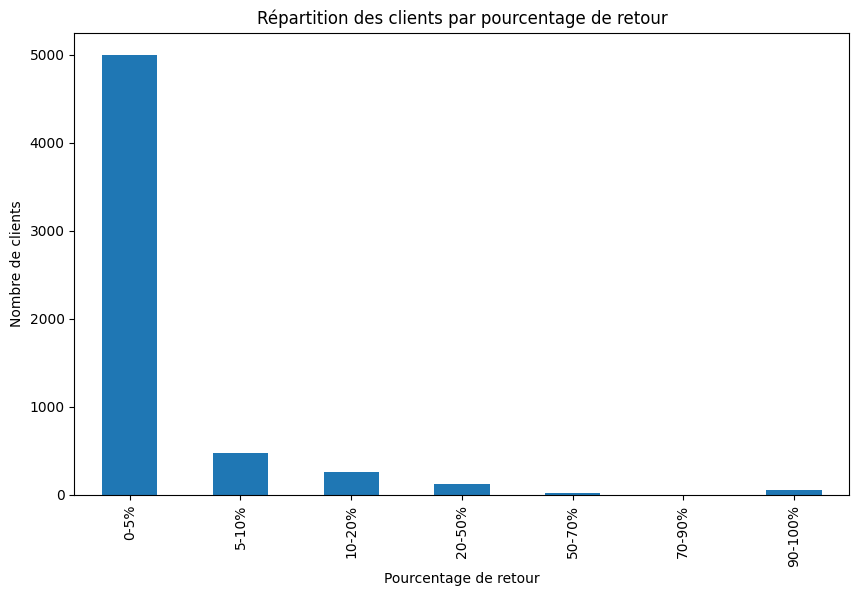

In [21]:
intervals = [0, 5, 10, 20, 50, 70, 90, 100]
labels = ['0-5%', '5-10%', '10-20%', '20-50%', '50-70%', '70-90%', '90-100%']

df_gp_cancellation['ReturnCategory'] = pd.cut(df_gp_cancellation['CancellationPercentage'], bins=intervals, labels=labels, right=True, include_lowest=True)

return_category_counts = df_gp_cancellation['ReturnCategory'].value_counts()

return_category_counts = return_category_counts.reindex(labels)

plt.figure(figsize=(10, 6))
return_category_counts.plot(kind='bar')
plt.xlabel('Pourcentage de retour')
plt.ylabel('Nombre de clients')
plt.title('Répartition des clients par pourcentage de retour')
plt.show()


La feature "CancellationPercentage" peut-être interessante à conserver dans le clustering

## Création du RFM

RFM ? Récence, Fréquence, Montant.

Récence : la date du dernier achat. Notez bien que l’on part du principe qu’une personne qui a acheté récemment chez vous a plus de chances de revenir commander chez vous.  

Fréquence : le nombre d’achats réalisé sur une période donnée. Plus un client achète régulièrement chez vous, plus il y a de chances pour qu’il achète à nouveau. Vous l’avez compris, on analyse ici son niveau de fidélité.  

Montant : la somme des achats cumulés sur une période donnée. Les gros acheteurs répondent mieux que les petits. On mesure ici la valeur client.

Trouver la date la plus récente

In [22]:
date_recente = df["InvoiceDate"].max()
print(date_recente)

2011-12-09 12:50:00


### Préparation des données RFM

In [26]:
# Calculer les valeurs RFM sur l'ensemble de la plage de dates
last_date = df["InvoiceDate"].max()
recency = (last_date - df.groupby("Customer ID")["InvoiceDate"].max()).dt.days
frequency = df.groupby("Customer ID")["Invoice"].nunique()
monetary_value = df.groupby("Customer ID")["TotalPrice"].sum()

# Créer un nouveau DataFrame avec les valeurs RFM
rfm_df = pd.DataFrame({
    "Recency": recency,
    "Frequency": frequency,
    "MonetaryValue": monetary_value
})

rfm_df.head(100)

,Recency,Frequency,MonetaryValue
Customer ID,,,
12346,325,15,52.76
12347,1,8,4921.53
12348,74,5,1658.40
12349,18,4,3654.54
12350,309,1,294.40
...,...,...,...
12443,731,1,365.31
12444,20,5,4085.46
12445,21,3,370.48
